                Open     High      Low     Close      Volume  Ex-Dividend  \
Date                                                                        
2004-08-19   100.010   104.06    95.96   100.335  44659000.0          0.0   
2004-08-20   101.010   109.08   100.50   108.310  22834300.0          0.0   
2004-08-23   110.760   113.48   109.05   109.400  18256100.0          0.0   
2004-08-24   111.240   111.60   103.57   104.870  15247300.0          0.0   
2004-08-25   104.760   108.00   103.88   106.000   9188600.0          0.0   
2004-08-26   104.950   107.95   104.66   107.910   7094800.0          0.0   
2004-08-27   108.100   108.62   105.69   106.150   6211700.0          0.0   
2004-08-30   105.280   105.49   102.01   102.010   5196700.0          0.0   
2004-08-31   102.320   103.71   102.16   102.370   4917800.0          0.0   
2004-09-01   102.700   102.97    99.67   100.250   9138200.0          0.0   
2004-09-02    99.090   102.37    98.94   101.510  15118600.0          0.0   

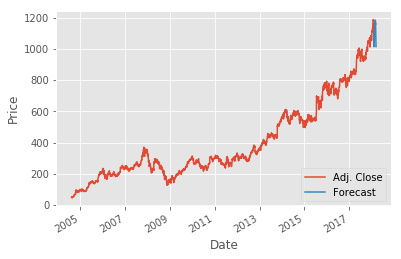

In [7]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib import style
import datetime

style.use('ggplot')

df = quandl.get("WIKI/GOOGL")
print(df)
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)
forecast_set = clf.predict(X_lately)
print(forecast_set)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()